# Create classifier with reconstructed licit and illicit nodes

In [2]:
from src.modelNoPCA import Autoencoder
from src.data import Data

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import torch
import pandas as pd
import numpy as np

### Retrieve the used data for the Autoencoder training and remove it from the data to train the classifier. 

In [3]:
AE_data = pd.read_csv('../../../data/noPCA_AEData2.csv') # don't use again the data used to train the autoencoder

classesDF  = pd.read_csv('../../../data/elliptic_txs_classes.csv')
# Remove all nodes that have unknown class
classesDF = classesDF[classesDF['class'] != "unknown"]
# If class = 2, then map to 0, else map to 1
classesDF['class'] = classesDF['class'].map({'2': 0, '1': 1})


featuresDF = pd.read_csv('../../../data/elliptic_txs_features.csv')
# Change column names --> Column 1 is txId, Column 2 is timestep and the rest are unknown features
featuresDF.columns = ['txId', 'timestep'] + ['f' + str(i) for i in range(165)]
# Remove all edges that do not appear in classesDF
featuresDF = featuresDF[featuresDF['txId'].isin(classesDF['txId'])]
# Append the class to the featuresDF based on txID
featuresDF = featuresDF.merge(classesDF, on='txId')

# Move features 'class' to first column
cols = list(featuresDF.columns)
cols = cols[:1] + [cols[-1]] + cols[1:-1]
featuresDF = featuresDF[cols]

# Take featuresDF and remove from it all rows that appear in AE_data
featuresDF = featuresDF[~featuresDF['txId'].isin(AE_data['txId'])]

featuresDF.head(5)

,txId,class,timestep,f0,f1,f2,f3,f4,f5,f6,...,f155,f156,f157,f158,f159,f160,f161,f162,f163,f164
9,232051089,0,1,-0.172914,-0.184668,-1.201369,-0.046932,-0.024025,-0.029140,-0.061584,...,-0.560956,-0.584179,1.039938,0.851388,0.018279,-0.068266,-0.093204,-0.068808,-0.120613,-0.119792
55,230674241,0,1,-0.007920,-0.184668,-1.201369,0.028105,-0.063725,0.054722,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
60,231995264,0,1,-0.172870,-0.158783,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.532262,-0.550539,-0.979074,-0.978556,0.018279,-0.029817,0.008288,0.031697,-1.760926,-1.760984
77,230681119,0,1,-0.109788,-0.184668,-1.201369,-0.046932,-0.043875,-0.029140,-0.061584,...,-0.577099,-0.600999,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
82,232415197,0,1,-0.168459,-0.184668,-1.201369,0.178180,-0.063725,0.138585,0.242712,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792


# Train the classifier with reconstruction loss

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
import torch.nn as nn

import matplotlib.pyplot as plt

In [5]:
# Normalize the data
scaler = StandardScaler()
scaler.fit(featuresDF.iloc[:, 2:])
featuresDF.iloc[:, 2:] = scaler.transform(featuresDF.iloc[:, 2:])

# vectors = featuresDF.iloc[:, 2:]
labels = featuresDF.iloc[:, 1].values

X_train, X_test, y_train, y_test = train_test_split(featuresDF, labels, test_size=0.2, random_state=42)

train_dataset = Data(X_train, y_train)
y_train = train_dataset.labels

test_dataset = Data(X_test, y_test)
y_test = test_dataset.labels

### Compute the reconstruction loss for every class

In [6]:
model = Autoencoder()
model.load_state_dict(torch.load('models/NoPCA_Autoencoder_secondRUN.pth'))
model.to('cuda')

model.eval()
with torch.no_grad():
    # Encode and decode the data
    train_labels = train_dataset.labels
    original_train = train_dataset.vectors
    reconstructed_train = model(train_dataset.vectors.to('cuda')).cpu()

    test_labels = test_dataset.labels
    original_test = test_dataset.vectors
    reconstructed_test =  model(test_dataset.vectors.to('cuda')).cpu()

In [7]:
# Assuming original_train and reconstructed_train_squeezed are your tensors
mse_loss = nn.MSELoss()
losses = []

for original, reconstruction in zip(original_train, reconstructed_train):
    loss = mse_loss(original, reconstruction)
    losses.append(loss.item())

In [8]:
fpr, tpr, thresholds = roc_curve(train_labels, losses, pos_label=0)
roc_auc = auc(fpr, tpr)

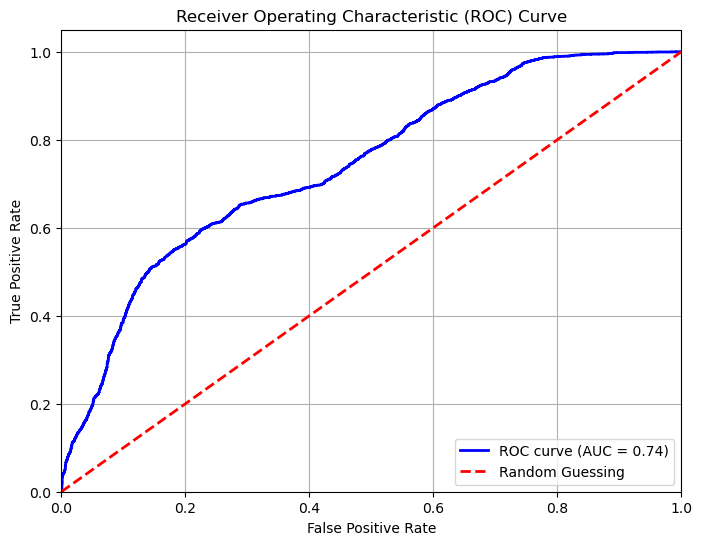

In [9]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random Guessing')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

### Calculate the metrics with the test data

In [10]:
# Obtain the best threshold for the ROC curve

# Calculate Youden's J statistic for each threshold
j_scores = tpr - fpr
# Find the index of the maximum J score
best_index = np.argmax(j_scores)
# Find the threshold corresponding to the maximum J score
best_threshold = thresholds[best_index]

In [11]:
mse_loss = nn.MSELoss()
losses = []

# Compute the losses for all reconstructions
for original, reconstruction in zip(original_test, reconstructed_test):
    loss = mse_loss(original, reconstruction)
    losses.append(loss.item())

# If loss is too big, anomaly detected, else, normal
threshold = best_threshold
predictions = [0 if loss > threshold else 1 for loss in losses]

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [13]:
accuracy = accuracy_score(test_labels, predictions)
conf_mat = confusion_matrix(test_labels, predictions)
class_report = classification_report(test_labels, predictions)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{class_report}')

Accuracy: 0.6743674367436744
Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.58      0.64       919
           1       0.64      0.77      0.70       899

    accuracy                           0.67      1818
   macro avg       0.68      0.68      0.67      1818
weighted avg       0.68      0.67      0.67      1818



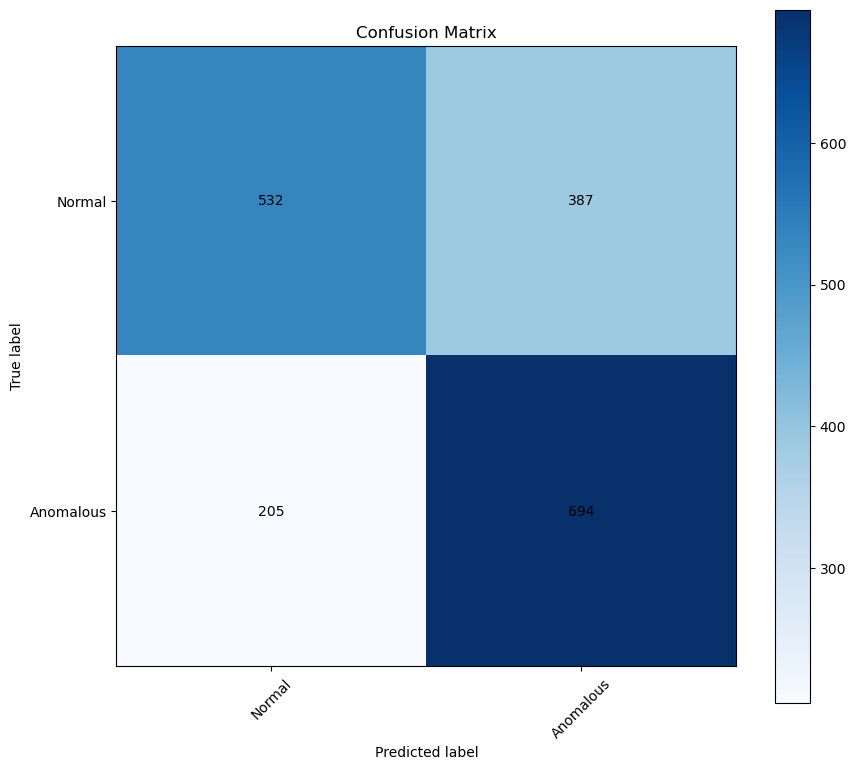

In [14]:
plt.figure(figsize=(10, 9)) 
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Confusion Matrix')
plt.colorbar()

for i in range(2):
    for j in range(2):
        plt.text(i, j, str(conf_mat[j, i]), ha='center', va='center')

plt.xticks([0, 1], ['Normal', 'Anomalous'], rotation=45)
plt.yticks([0, 1], ['Normal', 'Anomalous'])

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig(f'autoencoder_confusion_matrix.png')
plt.show()


# plt.figure(figsize=(10, 7))
# plt.matshow(conf_mat, cmap='Blues')
# plt.colorbar()

# plt.title('Confusion Matrix')
# plt.xlabel('Predicted')
# plt.ylabel('True')


# Train a random forest classifier with the reconstructed data

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

We will use the reconstructed train set to train this random forest classifier.

### Prepare the data and train the model

In [18]:
scaler = StandardScaler()
X, y = scaler.fit_transform(reconstructed_train), train_labels

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)

RandomForestClassifier(random_state=42)

### Test the classifier with the test data

In [19]:
X_test, y_test = scaler.transform(reconstructed_test), test_labels
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_mat = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{class_report}')

Accuracy: 0.9515951595159516
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95       919
           1       0.98      0.92      0.95       899

    accuracy                           0.95      1818
   macro avg       0.95      0.95      0.95      1818
weighted avg       0.95      0.95      0.95      1818



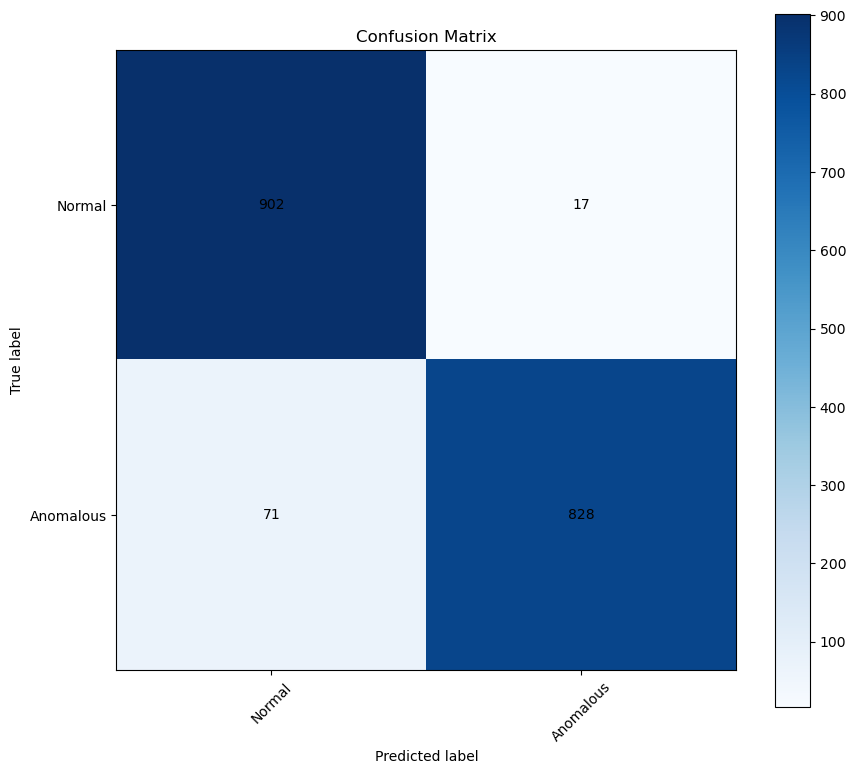

In [20]:
plt.figure(figsize=(10, 9))
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('Confusion Matrix')
plt.colorbar()
for i in range(2):
    for j in range(2):
        plt.text(i, j, str(conf_mat[j, i]), ha='center', va='center')
plt.xticks([0, 1], ['Normal', 'Anomalous'], rotation=45)
plt.yticks([0, 1], ['Normal', 'Anomalous'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig(f'random_forest_confusion_matrix.png')
plt.show()